In [ ]:
%pip install pyarrow

In [336]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import signal, interpolate, fftpack # signal processing lib
import glob
from tqdm import tqdm # pretty loading bar
import pyarrow.csv # faster .csv I/O than in pandas
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory

In [337]:
ROOT = "./watch_data_train/watch_data_train/"
SUBMISSION_SR = 30 # sampling rate for the submission file

In [338]:
train_ppgs_pathes = glob.glob(f"{ROOT}/PPG_EXP_*.csv")
train_ppgs_pathes.sort()
train_ecg_pathes = glob.glob(f"{ROOT}/ECG_EXP_*.csv")
train_ecg_pathes.sort()

In [339]:
ppg_dfs = []
ecg_dfs = []

In [340]:
for path in tqdm(train_ppgs_pathes):
    ppg_df = pyarrow.csv.read_csv(path).to_pandas()
    ppg_df.drop(columns=ppg_df.columns [0], axis= 1 , inplace= True )
    ppg_dfs.append(ppg_df)

for path in tqdm(train_ecg_pathes):
    ecg_df = pyarrow.csv.read_csv(path).to_pandas()
    ecg_df.drop(columns=ecg_df.columns [0], axis= 1 , inplace= True )
    ecg_dfs.append(ecg_df)

100%|██████████| 19/19 [00:00<00:00, 527.66it/s]


In [341]:
ppg_dfs[0]

,PPG_signal,Timestamp
0,0.000000e+00,0.000000
1,2.210106e+06,0.038635
2,2.204051e+06,0.063829
3,2.193746e+06,0.104256
4,2.190100e+06,0.116130
...,...,...
163437,1.556135e+06,5447.898561
163438,1.553211e+06,5447.923679
163439,1.560918e+06,5447.958554
163440,1.582995e+06,5448.003099


In [342]:
ecg_dfs[0]

,ECG_peaks
0,0.000000
1,0.751004
2,1.500007
3,2.252011
4,3.005015
...,...
7153,5446.761662
7154,5447.216997
7155,5447.672333
7156,5447.802333


In [343]:
time_stamp_0 = ppg_dfs[6]["Timestamp"].values

In [344]:
signal_0 = ppg_dfs[6]["PPG_signal"].values

In [345]:
ECG_peaks_0 = ecg_dfs[6]['ECG_peaks'].values

In [346]:
def arith_mean(f, buffer_size=10):
    # Creating buffer
    if not hasattr(arith_mean, "buffer"):
        arith_mean.buffer = [f] * buffer_size

    # Move buffer to actually values ( [0, 1, 2, 3] -> [1, 2, 3, 4] )
    arith_mean.buffer = arith_mean.buffer[1:]
    arith_mean.buffer.append(f)

    # Calculation arithmetic mean
    mean = 0
    for e in arith_mean.buffer: mean += e
    mean /= len(arith_mean.buffer)

    return mean

In [347]:
def kalman(f, q=0.25, r=0.7):
    if not hasattr(kalman, "Accumulated_Error"):
        kalman.Accumulated_Error = 1
        kalman.kalman_adc_old = 0

    if abs(f-kalman.kalman_adc_old)/50 > 0.25:
        Old_Input = f*0.382 + kalman.kalman_adc_old*0.618
    else:
        Old_Input = kalman.kalman_adc_old

    Old_Error_All = (kalman.Accumulated_Error**2 + q**2)**0.5
    H = Old_Error_All**2/(Old_Error_All**2 + r**2)
    kalman_adc = Old_Input + H * (f - Old_Input)
    kalman.Accumulated_Error = ((1 - H)*Old_Error_All**2)**0.5
    kalman.kalman_adc_old = kalman_adc

    return kalman_adc

In [348]:
def easy_mean(f, s_k=0.2, max_k=0.9, d=1.5):
    # Creating static variable
    if not hasattr(easy_mean, "fit"):
        easy_mean.fit = f

    # Adaptive ratio
    k = s_k if (abs(f - easy_mean.fit) < d) else max_k

    # Calculation easy mean
    easy_mean.fit += (f - easy_mean.fit) * k

    return easy_mean.fit

In [349]:
def median(f):
    # Creating buffer
    if not hasattr(median, "buffer"):
        median.buffer = [f] * 3

    # Move buffer to actually values ( [0, 1, 2] -> [1, 2, 3] )
    median.buffer = median.buffer[1:]
    median.buffer.append(f)

    # Calculation median
    a = median.buffer[0]
    b = median.buffer[1]
    c = median.buffer[2]
    middle = max(a, c) if (max(a, b) == max(b, c)) else max(b, min(a, c))

    return middle

In [350]:
# easy_mean_signal = [median(i) for i in list(signal_0)]
# easy_mean_signal = np.array(easy_mean_signal)
# easy_mean_signal = [easy_mean(i) for i in list(easy_mean_signal)]
# easy_mean_signal = np.array(easy_mean_signal)
easy_mean_signal = [arith_mean(i) for i in list(signal_0)]
easy_mean_signal = np.array(easy_mean_signal)
# easy_mean_signal = [kalman(i) for i in list(easy_mean_signal)]
# easy_mean_signal = np.array(easy_mean_signal)

In [351]:
start = 500
stop = 1000
num1 = 23
num2 = 45

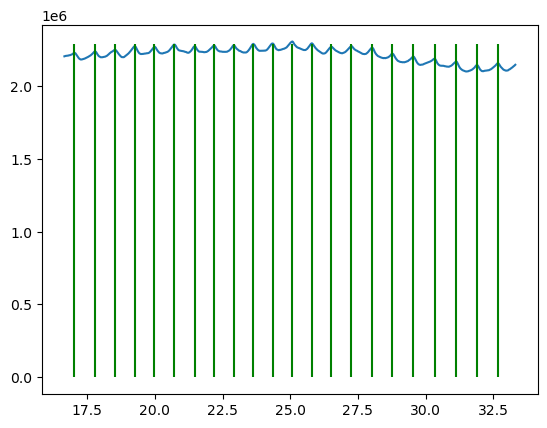

In [352]:
# sns.lineplot(x=time_stamp_0[:-2][start:stop], y=easy_mean_signal[start:stop])
sns.lineplot(x=time_stamp_0[start:stop], y=signal_0[start:stop])
plt.vlines(ECG_peaks_0[num1:num2], 0, easy_mean_signal[start:stop].max(), colors="green")

<AxesSubplot:>

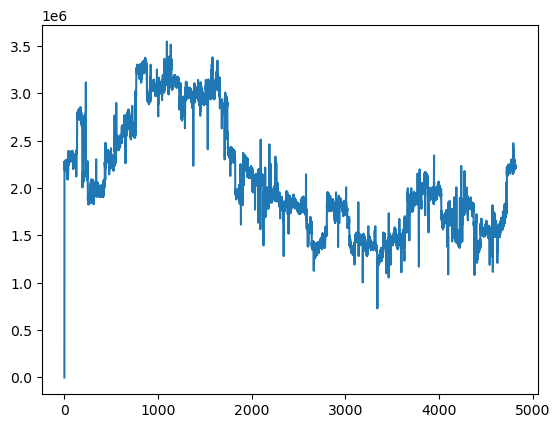

In [353]:
sns.lineplot(x=time_stamp_0, y=signal_0)

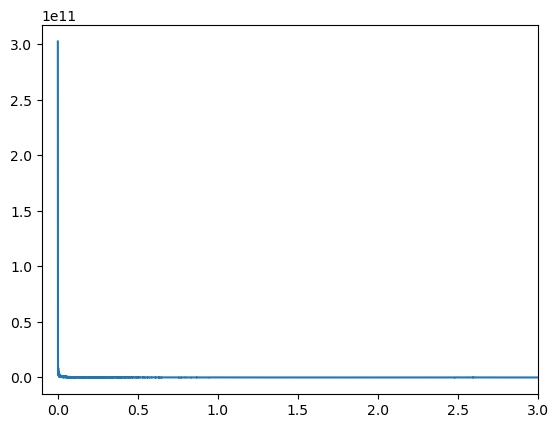

In [354]:
from scipy.fft import rfft, rfftfreq

N = SUBMISSION_SR * int(time_stamp_0.max() - time_stamp_0.min())

yf = rfft(signal_0)[:-1]
# xf = rfftfreq(N, 1/SUBMISSION_SR)
xf = np.linspace(0, SUBMISSION_SR, len(yf))

plt.plot(xf, np.abs(yf))
plt.xlim(-0.1, 3)
plt.show()

Text(0, 0.5, 'Filter power')

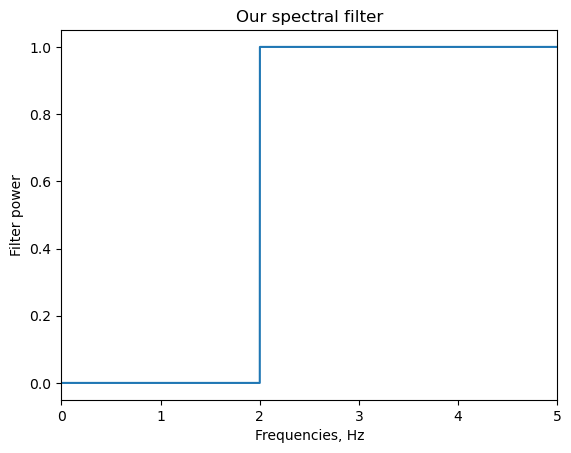

In [355]:
band_filter = np.zeros(len(xf))
band_filter[(xf > 2) & (xf< 20)] = 1

plt.title("Our spectral filter")
plt.plot(xf, band_filter)
plt.xlim(0, 5)
plt.xlabel("Frequencies, Hz")
plt.ylabel("Filter power")

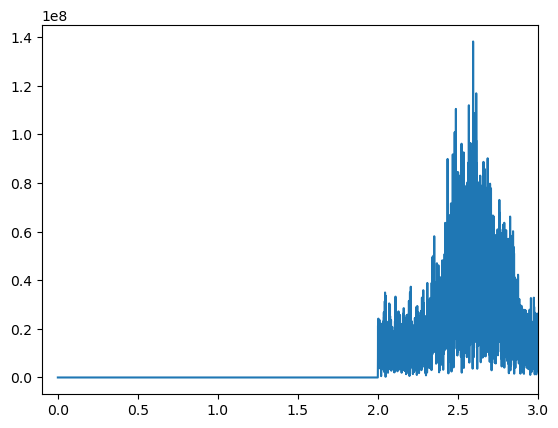

In [356]:
yf[band_filter == 0] = 0

plt.plot(xf, np.abs(yf))
plt.xlim(-0.1, 3)
plt.show()

<AxesSubplot:>

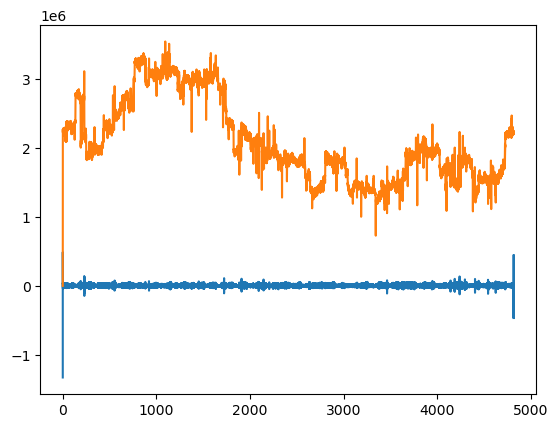

In [357]:
from scipy.fft import irfft

new_sig = irfft(yf)

sns.lineplot(x=time_stamp_0[:-2], y=new_sig)
sns.lineplot(x=time_stamp_0, y=signal_0)

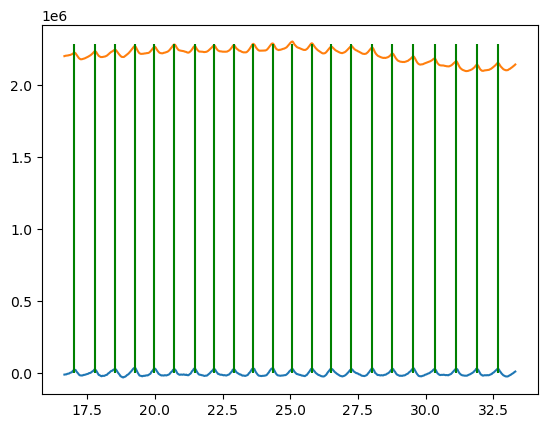

In [358]:
sns.lineplot(x=time_stamp_0[:-2][start:stop], y=new_sig[start:stop])
sns.lineplot(x=time_stamp_0[start:stop], y=signal_0[start:stop])
plt.vlines(ECG_peaks_0[num1:num2], 0, easy_mean_signal[start:stop].max(), colors="green")

In [359]:
ppg_peak_idxs = signal.find_peaks(new_sig)[0]
ppg_peaks = time_stamp_0[ppg_peak_idxs]

In [360]:
ppg_peaks.shape

(9874,)

In [361]:
ECG_peaks_0.shape

(6348,)

In [ ]:
def format_peaks_to_intervals(ppg_peaks, ts_start, ts_finish):
    """
    Formats the detected heart beat timestamps into the sequence of interbeat intervals. 
    The test ECG peaks are formatted in the same way.
    The start and finish of each experiment are the start and finish of the PPG data.
    """
    timestamps_interp = np.linspace(ts_start, ts_finish, int((ts_finish - ts_start) * SUBMISSION_SR))
    heartbeat_intervals = np.diff(ppg_peaks, prepend=ts_start)
    func = interpolate.interp1d(ppg_peaks, heartbeat_intervals, "nearest", bounds_error=False, fill_value=0)
    heartbeat_intervals_interp = func(timestamps_interp)
    return heartbeat_intervals_interp

In [ ]:
def process_exp(ppg_df):
    ppg_signal = ppg_df['PPG_signal'].values
    timestamps = ppg_df['Timestamp'].values
    ppg_peak_idxs = signal.find_peaks(ppg_signal)[0]
    ppg_peaks = timestamps[ppg_peak_idxs]
    ppg_rr_intervals_interp = format_peaks_to_intervals(ppg_peaks, timestamps[0], timestamps[-1])
    return ppg_rr_intervals_interp

In [ ]:
test_ppgs_pathes = glob.glob(f"{ROOT}/PPG_EXP_*.csv")
test_ppgs_pathes.sort()
all_predictions = []

In [ ]:
for path in tqdm(test_ppgs_pathes):
    ppg_df = pyarrow.csv.read_csv(path).to_pandas()
    ppg_rr_intervals_interp = process_exp(ppg_df)
    all_predictions.append(ppg_rr_intervals_interp)

In [ ]:
all_predictions = np.concatenate(all_predictions)
sample_summission = pd.DataFrame({"PPG_interbeat_interval": all_predictions})
sample_summission['id'] = sample_summission.index
# sample_summission.to_csv("submission.csv", index=None)

In [ ]:
sample_summission